In [1]:
import numpy as np
import matplotlib
import matplotlib.colors as mplcolors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sys


def random_mpl_color_rgb():
    return (np.random.uniform(), np.random.uniform(), np.random.uniform())


def random_mpl_color_rgba(alpha=0.25):
    rgba_tup = random_mpl_color_rgb() + (alpha,)
    return rgba_tup


def random_mpl_color_rgb_rgba(alpha=0.25):
    """
    generate a pair of rgb and rgba color, both of them have same R G B value.
    """
    rgb_tup = random_mpl_color_rgb()
    rgba_tup = rgb_tup + (alpha,)
    return rgb_tup, rgba_tup


class Boite:
    def __init__(self, point_ref, longeur, largeur, hauteur):
        assert isinstance(point_ref, tuple)
        assert len(point_ref) == 3
        self.x = point_ref[0]
        self.y = point_ref[1]
        self.z = point_ref[2]
        self.longeur = longeur
        self.largeur = largeur
        self.hauteur = hauteur

        # fristly we think the reference point is at the origin
        self._temp_sommets = np.array([[-longeur / 2.0, -largeur / 2.0, -hauteur / 2.0],
                                       [longeur / 2.0, -largeur / 2.0, -hauteur / 2.0],
                                       [longeur / 2.0, largeur / 2.0, -hauteur / 2.0],
                                       [-longeur / 2.0, largeur / 2.0, -hauteur / 2.0],
                                       [-longeur / 2.0, -largeur / 2.0, hauteur / 2.0],
                                       [longeur / 2.0, -largeur / 2.0, hauteur / 2.0],
                                       [longeur / 2.0, largeur / 2.0, hauteur / 2.0],
                                       [-longeur / 2.0, largeur / 2.0, hauteur / 2.0]])

    def translation(self, length_x, length_y, length_z):
        self.x = self.x + length_x
        self.y = self.y + length_y
        self.z = self.z + length_z

    def rotation3d(self, alpha, beta, gamma):
        """
        :param alpha: perform a rotation about x axis
        :param beta: perform a rotation about y axis
        :param gamma: perform a rotation about z axis
        :return:
        """
        rx = np.array([[1, 0, 0],
                       [0, np.cos(alpha), -np.sin(alpha)],
                       [0, np.sin(alpha), np.cos(alpha)]])
        ry = np.array([[np.cos(beta), 0, np.sin(beta)],
                       [0, 1, 0],
                       [-np.sin(beta), 0, np.cos(beta)]])
        rz = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                       [np.sin(gamma), np.cos(gamma), 0],
                       [0, 0, 1]])
        self._temp_sommets = np.transpose(rz.dot(ry.dot(rx.dot(np.transpose(self._temp_sommets)))))
        self._update_verts()

    def _update_sommets(self):
        # after some operation we need to translate object to real location.
        self.sommets = np.ones((self._temp_sommets.shape[0], 1)) * np.array(
            [self.x, self.y, self.z]) + self._temp_sommets

    def _update_verts(self):
        # obtain all surfaces.
        self._update_sommets()
        self.verts = [[self.sommets[0], self.sommets[1], self.sommets[2], self.sommets[3]],
                      [self.sommets[4], self.sommets[5], self.sommets[6], self.sommets[7]],
                      [self.sommets[0], self.sommets[1], self.sommets[5], self.sommets[4]],
                      [self.sommets[2], self.sommets[3], self.sommets[7], self.sommets[6]],
                      [self.sommets[1], self.sommets[2], self.sommets[6], self.sommets[5]],
                      [self.sommets[4], self.sommets[7], self.sommets[3], self.sommets[0]]]

    def getVerts(self):
        self._update_verts()
        return self.verts

    def getSommets(self):
        self._update_sommets()
        return self.sommets

    def getPoly3d(self, facecolors=None, edgecolors=None):
        if facecolors == None and edgecolors == None:
            edgecolors, facecolors = random_mpl_color_rgb_rgba()
        elif facecolors == None and edgecolors != None:
            if isinstance(edgecolors, str):
                edgecolors = mplcolors.to_rgb(edgecolors)
            assert isinstance(edgecolors, tuple)
            facecolors = (edgecolors[0], edgecolors[1], edgecolors[2]) + (0.25,)
        elif edgecolors == None and facecolors != None:
            if isinstance(facecolors, str):
                facecolors = mplcolors.to_rgb(facecolors)
            assert isinstance(facecolors, tuple)
            edgecolors = (facecolors[0], facecolors[1], facecolors[2])
        self._update_verts()
        poly3d = Poly3DCollection(self.verts,
                                  facecolors=facecolors, linewidths=1, edgecolors=edgecolors)
        return poly3d


class Camion(Boite):
    def __init__(self, point_ref, longeur, largeur, hauteur):
        super().__init__(point_ref, longeur, largeur, hauteur)

    @classmethod
    def atOrigine(cls, longeur, largeur, hauteur):
        return cls((longeur / 2.0, largeur / 2.0, hauteur / 2.0), longeur, largeur, hauteur)

    def init(self, camion_color=(1, 1, 1, 0), edgecolors="black"):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection="3d")
        self.ax1.set_aspect(1)
        self.ax1.add_collection3d(super().getPoly3d(facecolors=camion_color, edgecolors=edgecolors))

    def addPoly3d(self, poly3d):
        self.ax1.add_collection3d(poly3d)

    def draw(self, show_axis=False, show_axis_label=False, show_grid=False):
        axis_switch = "on" if show_axis else "off"
        plt.axis(axis_switch)
        if show_axis_label == True:
            self.ax1.set_xlabel("X")
            self.ax1.set_ylabel("Y")
            self.ax1.set_zlabel("Z")
        self.ax1.grid(show_grid)
        plt.show()


#####################################################################
def overlap2d(center_1, length_1, width_1, center_2, length_2, width_2):
    overlap_length = max(0, min(center_1[0] + length_1/2, center_2[0]+length_2/2) -
                        max(center_1[0] - length_1/2, center_2[0] - length_2/2))
    overlap_width = max(0, min(center_1[1] + width_1/2, center_2[1]+width_2/2) -
                        max(center_1[1] - width_1/2, center_2[1] - width_2/2))
    overlap_area = overlap_length * overlap_width
    ret = False
    if overlap_area != 0:
        ret = True
    return ret, overlap_area, overlap_length, overlap_width

def addGravity(X, B):
    X_copy = X.copy()
    z_set = set(X_copy[:, 2])
    placement_order = []
    while (len(z_set) != 0):
        lowest_z = min(z_set)
        idx = X_copy[:, 2] == lowest_z
        msg_str = []
        for i, j in enumerate(list(idx)):
            if j == True:
                msg_str.append(i)
        # print("lowest z: {}, Number of lowest composant: {}".format(lowest_z, msg_str))
        placement_order.extend(msg_str)
        z_set.remove(lowest_z)

    # print("Placement order: ", placement_order)

    placed_list = []
    for composant_i in placement_order:
        # print("considering composant i >>> {} ...".format(composant_i))
        # print(placed_list)
        z_last_composant = 0
        if len(placed_list) != 0:
            overlap_list = []
            for composant_j in placed_list:
                # print("--composant j >>> {}".format(composant_j))
                ret, _, overlap_length, overlap_width = overlap2d(X_copy[composant_i], B[composant_i, 0], B[composant_i, 1],
                                   X_copy[composant_j], B[composant_j, 0], B[composant_j, 1])
                if (ret and overlap_length>0.1 and overlap_width >0.1):
                    overlap_list.append(composant_j)
            # print("overlap_list: {}".format(overlap_list))
            if len(overlap_list) == 0:
                z_last_composant = 0
            else:
                z_last_composant = np.max(X_copy[overlap_list, 2] + B[overlap_list, 2] / 2)
        z_i = B[composant_i, 2] / 2 + z_last_composant
        # print("z_i: ", z_i)
        X_copy[composant_i, 2] = z_i

        placed_list.append(composant_i)
    return X_copy

[10. 10. 10.]


<IPython.core.display.Javascript object>


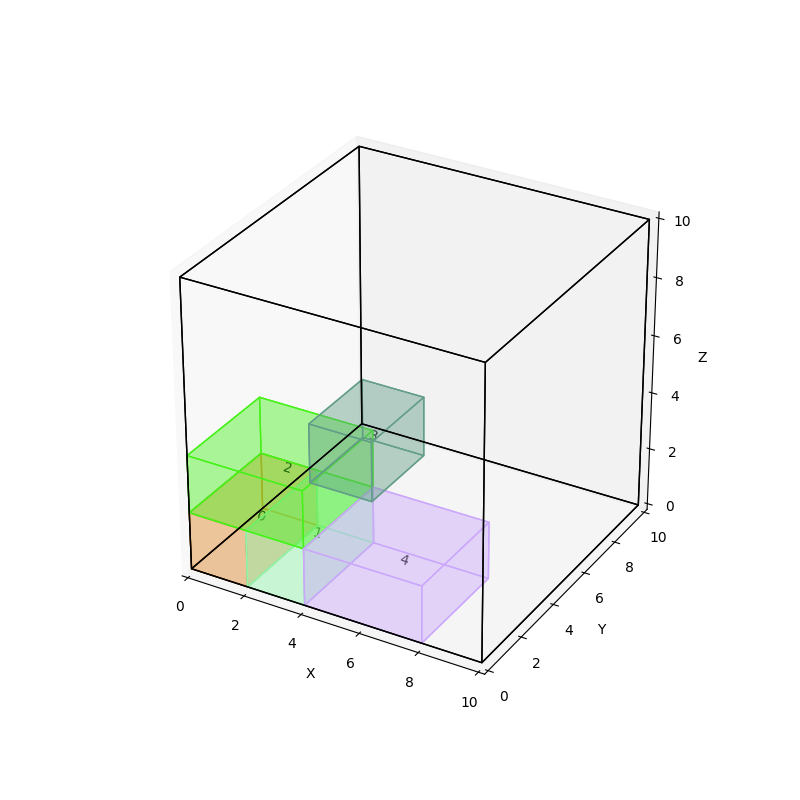

In [2]:
X = np.array([[1,2,1], [3,2,1], [2,2,3], [5,2,5], [6,2,1]]).astype(float)
B = np.array([[2, 4, 2], [2,4,2], [4,4,2], [2.1,3,2], [4,4, 2]]).astype(float)
C = np.load("C.npy")
print(C)
nb_composant = X.shape[0]
%matplotlib notebook
boite_color_list = []
for i in range(nb_composant):
    boite_color_list.append(random_mpl_color_rgba())

camion = Camion.atOrigine(C[0], C[1], C[2]);
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection="3d")    
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_xlim(-0, C[0])
ax1.set_ylim(-0, C[1])
ax1.set_zlim(-0, C[2])
ax1.grid(False)
ax1.add_collection3d(camion.getPoly3d(facecolors=(1, 1, 1, 0), edgecolors="black"))
boite_list = []
for i in range(X.shape[0]):
    boite = Boite((X[i, 0], X[i, 1], X[i, 2]), B[i, 0], B[i, 1], B[i, 2])
    boite_list.append(boite)
    ax1.add_collection3d(boite.getPoly3d(facecolors=boite_color_list[i]))
    ax1.text(*X[i, :], str(i), 'x')
plt.show()

<IPython.core.display.Javascript object>


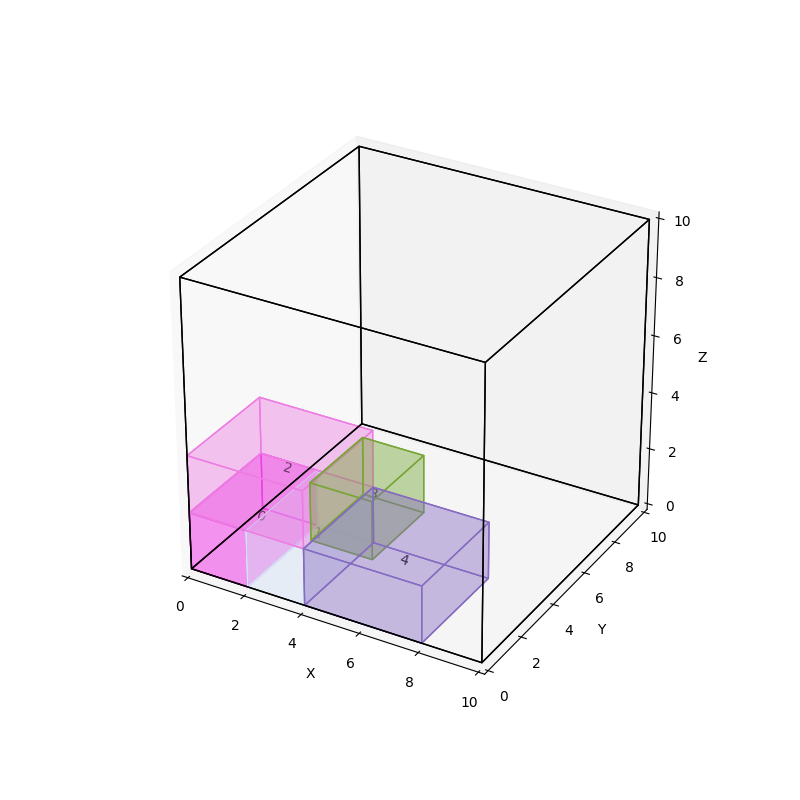

In [3]:
X = addGravity(X, B)
%matplotlib notebook
boite_color_list = []
for i in range(nb_composant):
    boite_color_list.append(random_mpl_color_rgba())

camion = Camion.atOrigine(C[0], C[1], C[2]);
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection="3d")    
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_xlim(-0, C[0])
ax1.set_ylim(-0, C[1])
ax1.set_zlim(-0, C[2])
ax1.grid(False)
ax1.add_collection3d(camion.getPoly3d(facecolors=(1, 1, 1, 0), edgecolors="black"))
boite_list = []
for i in range(X.shape[0]):
    boite = Boite((X[i, 0], X[i, 1], X[i, 2]), B[i, 0], B[i, 1], B[i, 2])
    boite_list.append(boite)
    ax1.add_collection3d(boite.getPoly3d(facecolors=boite_color_list[i]))
    ax1.text(*X[i, :], str(i), 'x')
plt.show()

In [4]:
def load_bearing_test(X, B, composants_weight, load_bearing_capacity):
    X_copy = X.copy()
    load_bearing_list = np.zeros((X_copy.shape[0]))
    upper_surface_list = X_copy[:, 2] + B[:, 2]/2.0
    z_set = set(upper_surface_list)
    placement_order = []
    while (len(z_set) != 0):
        lowest_z = min(z_set)
        idx = upper_surface_list == lowest_z
        msg_str = []
        for i, j in enumerate(list(idx)):
            if j == True:
                msg_str.append(i)
#         print("lowest z: {}, Number of lowest composant: {}".format(lowest_z, msg_str))
        placement_order.extend(msg_str)
        z_set.remove(lowest_z)

    print("Placement order: ", placement_order)

    placed_list = []
    # load_bearing_composants ids 
    load_bearing_list = [None for i in range(len(placement_order))]
    # load_bearing area 
    load_bearing_area_list = [None for i in range(len(placement_order))]
    
    for composant_i in placement_order:
#         print("considering composant i >>> {} ...".format(composant_i))
#         print(placed_list)
        if len(placed_list) != 0:
            overlap_list = []
            overlap_area_list = []
            for composant_j in placed_list:
#                 print("--composant j >>> {}".format(composant_j))
                ret, overlap_area, overlap_length, overlap_width = overlap2d(X_copy[composant_i], B[composant_i, 0], B[composant_i, 1],
                                   X_copy[composant_j], B[composant_j, 0], B[composant_j, 1])
                if (ret and overlap_length>0.1 and overlap_width>0.1):
                    overlap_list.append(composant_j)
                    overlap_area_list.append(overlap_area)
#             print("overlap_list: {}".format(overlap_list))
            if len(overlap_list) != 0:
                highest_z = np.max(upper_surface_list[overlap_list])
                idx = upper_surface_list[overlap_list] == highest_z
#                 print("overlap composant: ", np.array(overlap_list)[idx])
#                 print("overlap area: ", np.array(overlap_area_list)[idx])
                load_bearing_list[composant_i] = list(np.array(overlap_list)[idx])
                load_bearing_area_list[composant_i] = list(np.array(overlap_area_list)[idx])

        placed_list.append(composant_i)
        
    
    print("load_bearing list: ", load_bearing_list)
    print("load_bearing_area_list: ",load_bearing_area_list)
    load_bearing_weights = np.zeros((X_copy.shape[0]))
#     for composant_i in range(X_copy.shape[0]):
    placement_order.reverse()
    for composant_i in placement_order:
        # if exist one or more composants support composant i
        if load_bearing_list[composant_i] != None:
            for i, composant_j in enumerate(load_bearing_list[composant_i]):
                total_overlap_area = np.sum(np.array(load_bearing_area_list[composant_i]))
                # something like pressure
                load_bearing_weight_of_j =( composants_weight[composant_i] + load_bearing_weights[composant_i])*(load_bearing_area_list[composant_i][i]/total_overlap_area)
                load_bearing_weights[composant_j] = load_bearing_weights[composant_j] + load_bearing_weight_of_j
                
    print("load_bearing_weights: ", load_bearing_weights)
    print("load_bearing_capacity: ", load_bearing_capacity)
    
    res = 0
    if np.any(load_bearing_weights>load_bearing_capacity):
        not_meet_requirements_idx = load_bearing_weights>load_bearing_capacity
        res = np.sum(load_bearing_weights[not_meet_requirements_idx] - load_bearing_capacity[not_meet_requirements_idx])
        return res
    else:
        return res

In [5]:
weights_list = np.array([40, 20, 10, 10, 60])
# weights that composants can bear.
load_bearing_capacity_list = np.array([30, 25, 9, 10, 60]).astype(float)
load_bearing_test(X, B, weights_list, load_bearing_capacity_list)

Placement order:  [0, 1, 4, 2, 3]
load_bearing list:  [None, None, [0, 1], [4], None]
load_bearing_area_list:  [None, None, [8.0, 8.0], [6.1499999999999995], None]
load_bearing_weights:  [ 5.  5.  0.  0. 10.]
load_bearing_capacity:  [30. 25.  9. 10. 60.]


0

In [6]:
def compute_contact_area(X, B, C):
    """
    fonction objectifs: compute all contact area between one composant and another,
    and add contact area between composants and lower surface of container.
    """
    X_copy = X.copy()
    B_copy = B.copy()

    ## suppose lower surface of container is a composant with height equal to 0
    X_copy = np.vstack((np.array([C[0] / 2, C[1] / 2, 0]), X_copy))
    B_copy = np.vstack((np.array([C[0], C[1], 0]), B_copy))
    print(X)
    print(B)
    m = X_copy.shape[0]
    d = X_copy.shape[1]
    contact_area_total = 0
    print("m = {}, d={}".format(m, d))
    for i in range(m - 1):
        for j in range(i + 1, m):
            contact_area_length_list = []
            print("composant i = {}; j= {};".format(i-1, j-1))
            for k in range(d):
                contact_area_length =  min(X_copy[i, k] + B_copy[i, k] / 2.0, X_copy[j, k] + B_copy[j, k] / 2.0) - max(X_copy[i, k] - B_copy[i, k] / 2.0, X_copy[j, k] - B_copy[j, k] / 2.0)
                contact_area_length_list.append(contact_area_length)
                print("k = {}, contact_area_length = {}".format( k, contact_area_length))
            contact_area = 0
            if (np.all(np.array(contact_area_length_list) >= 0)):
                contact_area_length_list = list(filter(lambda a: a >0.1, contact_area_length_list))
                print("\t contact_area_length_list: {}".format(contact_area_length_list))
                if (len(contact_area_length_list) == 2):
                    contact_area = contact_area_length_list[0] * contact_area_length_list[1]
                else:
                    print("no contact")
                contact_area_total += contact_area
            else:
                print("no contact")
    return contact_area_total

<IPython.core.display.Javascript object>


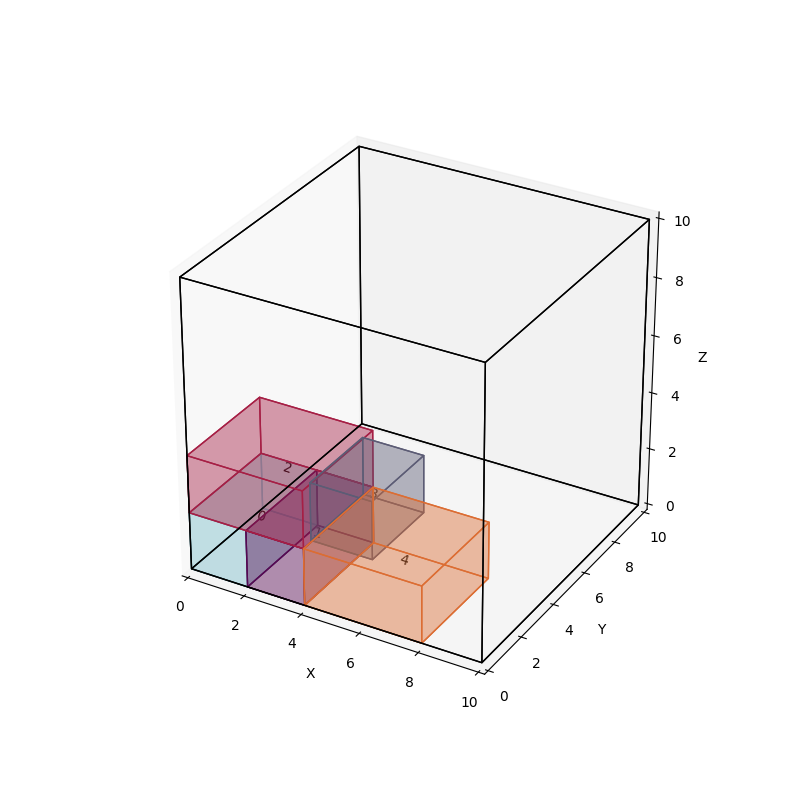

[[1. 2. 1.]
 [3. 2. 1.]
 [2. 2. 3.]
 [5. 2. 3.]
 [6. 2. 1.]]
[[2.  4.  2. ]
 [2.  4.  2. ]
 [4.  4.  2. ]
 [2.1 3.  2. ]
 [4.  4.  2. ]]
m = 6, d=3
composant i = -1; j= 0;
k = 0, contact_area_length = 2.0
k = 1, contact_area_length = 4.0
k = 2, contact_area_length = 0.0
	 contact_area_length_list: [2.0, 4.0]
composant i = -1; j= 1;
k = 0, contact_area_length = 2.0
k = 1, contact_area_length = 4.0
k = 2, contact_area_length = 0.0
	 contact_area_length_list: [2.0, 4.0]
composant i = -1; j= 2;
k = 0, contact_area_length = 4.0
k = 1, contact_area_length = 4.0
k = 2, contact_area_length = -2.0
no contact
composant i = -1; j= 3;
k = 0, contact_area_length = 2.0999999999999996
k = 1, contact_area_length = 3.0
k = 2, contact_area_length = -2.0
no contact
composant i = -1; j= 4;
k = 0, contact_area_length = 4.0
k = 1, contact_area_length = 4.0
k = 2, contact_area_length = 0.0
	 contact_area_length_list: [4.0, 4.0]
composant i = 0; j= 1;
k = 0, contact_area_length = 0.0
k = 1, contact_area_lengt

76.15

In [7]:

%matplotlib notebook
boite_color_list = []
for i in range(nb_composant):
    boite_color_list.append(random_mpl_color_rgba())

camion = Camion.atOrigine(C[0], C[1], C[2]);
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection="3d")    
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_xlim(-0, C[0])
ax1.set_ylim(-0, C[1])
ax1.set_zlim(-0, C[2])
ax1.grid(False)
ax1.add_collection3d(camion.getPoly3d(facecolors=(1, 1, 1, 0), edgecolors="black"))
boite_list = []
for i in range(X.shape[0]):
    boite = Boite((X[i, 0], X[i, 1], X[i, 2]), B[i, 0], B[i, 1], B[i, 2])
    boite_list.append(boite)
    ax1.add_collection3d(boite.getPoly3d(facecolors=boite_color_list[i]))
    ax1.text(*X[i, :], str(i), 'x')
plt.show()
compute_contact_area(X,B,C)